In [1]:
!pip uninstall jupyter themes

^C


In [1]:
!pip install pyspark
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 7.9 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824025 sha256=f6f32f33bc455211d34bc5e30b145199e8c3a7b11fe64b47b1e842bce93251cb
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder.appName("XGBoostClassifier")\
         .getOrCreate()
)

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
!unzip /content/drive/MyDrive/Colab\ Notebooks/alfabattle2_train_transactions_contest.zip

Archive:  /content/drive/MyDrive/Colab Notebooks/alfabattle2_train_transactions_contest.zip
 extracting: alfabattle2_train_transactions_contest/.Rhistory  
  inflating: alfabattle2_train_transactions_contest/part_000_0_to_23646.parquet  
  inflating: alfabattle2_train_transactions_contest/part_001_23647_to_47415.parquet  
  inflating: alfabattle2_train_transactions_contest/part_002_47416_to_70092.parquet  
  inflating: alfabattle2_train_transactions_contest/part_003_70093_to_92989.parquet  
  inflating: alfabattle2_train_transactions_contest/part_004_92990_to_115175.parquet  
  inflating: alfabattle2_train_transactions_contest/part_005_115176_to_138067.parquet  
  inflating: alfabattle2_train_transactions_contest/part_006_138068_to_159724.parquet  
  inflating: alfabattle2_train_transactions_contest/part_007_159725_to_180735.parquet  
  inflating: alfabattle2_train_transactions_contest/part_008_180736_to_202834.parquet  
  inflating: alfabattle2_train_transactions_contest/part_009_2028

In [5]:
import pyspark
from pyspark.sql.types import *
from pyspark.sql import functions
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler
from xgboost.spark import SparkXGBClassifier
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
import os

def preprocess(df):
# getting the numerical columns
    cat_columns = []
    num_columns = ['amnt','hour','days_before','weekofyear','hour_diff']
    for column in df.columns:
        if column not in num_columns:
            cat_columns.append(column)

    cat_columns.remove('app_id')
    cat_columns.remove('transaction_number')
    cat_columns.remove('__index_level_0__')
    # creating a new dataframe
    new_df = df.select('app_id').distinct()

    # handling the categorical columns
    for column in cat_columns:
        # grouping by app_id and categorical column & counting the occurences 
        cnts = df.groupby('app_id',column).count()
        
        # extracting the maximum count and its app_id 
        max_cnt = cnts.groupby('app_id').agg(max('count').alias('count'))
        
        # extracting the frequently occuring value
        mode = cnts.join(max_cnt,['app_id','count'],'inner')\
        .select('app_id',column)\
        .withColumnRenamed(column,'mode_'+column)
        
        # appending the newly created column to the original dataframe
        new_df = new_df.join(mode,'app_id','inner')
        
    # handling numerical columns
    for column in num_columns:
        # calculating the average of the numerical features
        avgs = df.groupby('app_id').agg(mean(column).alias('avg_'+column))
        
        # appending the column to the dataframe
        new_df = new_df.join(avgs,'app_id','inner')
    # returning the preprocessed dataframe
    return new_df

def getData(parquet_path,csv_path):
    df = spark.read.parquet(parquet_path)
    # applying preprocessig to reduce the data
    df = preprocess(df)
    # reading the csv file
    csv = spark.read.format("csv")\
    .option("header","True")\
    .option("inferSchema","True")\
    .load(csv_path)
    # merging the csv and the parquet file
    df = df.join(csv,'app_id',"inner")
    # droping the app_id column
    df = df.drop('app_id')
    # returning the cleaned data frame
    return df

def buildPipeline(df):
    """
    This model creates a pipeline and return the pipeline model which can be trained
    """
    # getting the name of the feature columns
    features = df.columns[:len(df.columns)-1]
    # creating object of VectorAssembler
    assemble = VectorAssembler(inputCols=features,outputCol='features')
    # creating object of classifier model
    classifier = SparkXGBClassifier(seed=7,label_col="flag",\
                                    features_col="features",eval_metric='logloss',\
                                    use_gpu=True,num_workers=1)
    STAGES = [assemble,classifier]
    # creating an object of Pipeline
    pipeline = Pipeline(stages=STAGES)

    # Setting the parameter grid for parameter tuning
    paramGrid = ParamGridBuilder() \
    .addGrid(classifier.max_depth, [3,5]) \
    .build()

    tvs = TrainValidationSplit(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=MulticlassClassificationEvaluator(labelCol="flag", predictionCol="prediction"),
    parallelism=2,
    trainRatio=0.7)  # data is separated by 70% and 30%, in which the former is used for training and the latter for evaluation
    return tvs

In [6]:
parquet_path = "/content/alfabattle2_train_transactions_contest"
csv_path = "/content/drive/MyDrive/Colab\ Notebooks/alfabattle2_train_target.csv"
df = getData(parquet_path,csv_path)

In [7]:
split = df.randomSplit([0.7,0.3],seed=7)

In [8]:
tvs = buildPipeline(split[0])
model = tvs.fit(split[0])

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:782: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


In [9]:
model.validationMetrics

[0.9603831047434316, 0.9615339048541628]

In [16]:
model.bestModel.save('/content/drive/MyDrive/Colab Notebooks/XGBoost1')

In [14]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Create both evaluators
evaluator = MulticlassClassificationEvaluator(labelCol="flag", predictionCol="prediction")

# Make predicitons
pred = model.transform(split[1]).select("flag", "prediction")

# Get metrics
acc = evaluator.evaluate(pred, {evaluator.metricName: "accuracy"})
f1 = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
weightedPrecision = evaluator.evaluate(pred, {evaluator.metricName: "weightedPrecision"})
weightedRecall = evaluator.evaluate(pred, {evaluator.metricName: "weightedRecall"})

In [15]:
print('Accuracy : ',acc)
print('F1  : ',f1)
print('Precision :',weightedPrecision)
print('Recall :',weightedRecall)

Accuracy :  0.9739414562573261
F1  :  0.9619379781363544
Precision : 0.9740018581452714
Recall : 0.9739414562573261


In [17]:
cf = pred.toPandas()

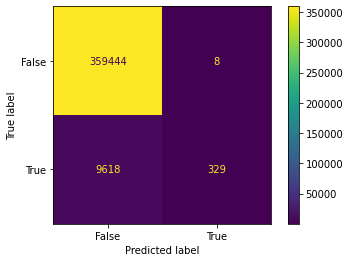

In [18]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(cf.flag, cf.prediction)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
import matplotlib.pyplot as plt
cm_display.plot()
plt.show()